In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

import westworld
from westworld.assets import *
from westworld.colors import *
from westworld.objects import *
from westworld.agents import *
from westworld.environment import *
from westworld.simulation import *
from westworld.logger import Logger

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


##### References
- https://medium.com/analytics-vidhya/simulating-the-solar-system-with-under-100-lines-of-python-code-5c53b3039fc6
- http://www.petercollingridge.co.uk/tutorials/pygame-physics-simulation/
- https://github.com/apisarenco/naive-n-body-sim/blob/master/main.py
- http://www.cs.ucy.ac.cy/~ppapap01/nbody/Presentation.pdf

##### Ideas
- Switch to vector fields (with speed and position vector), maybe useful to define gravitational fields, or direction fields in mobility simulations
- Add eating behavior where planets colliding forms bigger planets, but super big planets exploding
- Visualize force fields with heatmaps

##### TODO
- Add option to visualize in the notebook without saving to video
- Circle collides does not work right now

# Playground

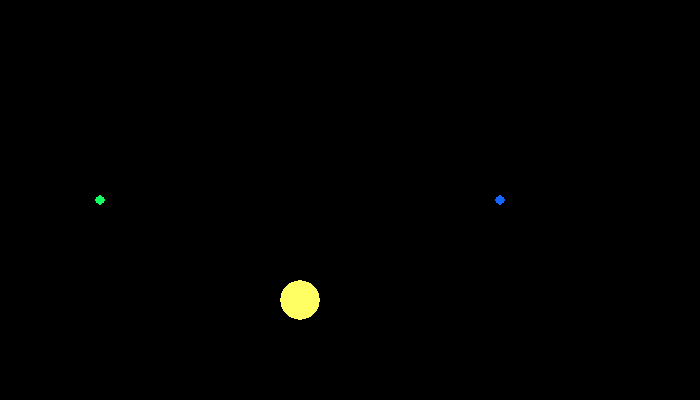

In [16]:
G = 10


class Planet(BaseAgent):
    
    def __init__(self,x,y,mass,radius,mobile = True,*args,**kwargs):
        
        self.mass = mass
        self.mobile = mobile
        self._radius = radius
        
        self.r = np.array([x,y],dtype = np.float32)
        self.v = np.array([0,0],dtype = np.float32)
        self.a = np.array([0,0],dtype = np.float32)


        super().__init__(x,y,*args,**kwargs,circle = True,width = radius*2,height = radius*2,collision_method = "circle")
        
    @property
    def blocking(self):
        return True
    
    
    def calculate_acceleration(self):
        
        a = np.array([0,0],dtype = np.float32)
        
        for planet in self.env.objects:
            
            if planet.id != self.id:
            
                r = planet.r - self.r
                a_planet = (G * planet.mass * r) / (np.sum(r**2)**(3./2))
                a += a_planet
            
        return a

    
    
    def step_euler(self,dt):
        
#         if self.mass < 500:
#             print(self.a[0],self.v[0],self.r[0])
# #         print("sun" if self.mass > 20 else "earth"," ->", self.a,self.v,self.r)
        
        self.r += self.v * dt # Forward euler pass
        self.a = self.calculate_acceleration()
        self.v += self.a * dt  # Backward euler pass (acceleration is updated)
    
    
    def step(self):
        
        if self.mobile:

            self.step_euler(1)
            x = int(self.r[0])
            y = int(self.r[1])
            self.move_at(x,y)
            
    def when_blocked(self,collisions):
        if self.mobile:
            self.kill()
            self.env.finish_episode()
        
    
sun = Planet(350,200,mass = 100,radius = 30,color = (255,205,66),mobile = False)
earth = Planet(500,200,mass = 10,radius = 5,color = (20,100,255))
earth2 = Planet(100,200,mass = 20,radius = 5,color = (20,255,100))
earth3 = Planet(300,300,mass = 100,radius = 20,color = (255,255,100))



earth.v += np.array([0,2])
earth2.v += np.array([0,-1])
earth3.v += np.array([0.5,-0.5])

class Space(SpatialEnvironment):
    
    def compute_reward(self):
        return 1
    
    
    def post_step(self):
        self.is_out()
    
    def is_out(self):
        for obj in self.objects:
            x,y = obj.x,obj.y
            if x < 0 or y < 0 or x > self.width or y > self.height:
                self.finish_episode()


env = Space(width = 700,height = 400,objects = [earth,earth2,earth3],toroidal = False)
env.render()
env.get_img()

In [6]:
sim = Simulation(env,fps = 50)
sim.run_episode(n_steps = 1000,replay = True,fps_replay = 25,render = True)

interactive(children=(Play(value=0, description='Press play', interval=40, max=156), Output()), _dom_classes=(…

IntSlider(value=0, max=156)

156

# Reinforcement Learning for orbit stability

In [17]:
import optuna

In [18]:
study = optuna.create_study(direction= "maximize")

In [26]:
def objective(trial):

    sun = Planet(350,200,mass = 100,radius = 20,color = (255,205,66),mobile = False)
    earth = Planet(50,200,mass = 5,radius = 5,color = (20,255,100))
    venus = Planet(150,200,mass = 5,radius = 5,color = (20,100,255))

    
    for i,p in enumerate([earth,venus]):
        vx = trial.suggest_uniform(f"vx{i}",-2,2)
        vy = trial.suggest_uniform(f"vy{i}",-2,2)
        
        p.v += np.array([vx,vy])
    


    env = Space(width = 700,height = 400,objects = [sun,earth,venus],toroidal = False)
    sim = Simulation(env,fps = 50)
    reward = sim.run_episode(n_steps = 3000,replay = True,fps_replay = 25,render = False)
    return reward

In [27]:
study.optimize(objective,n_trials = 100)

[I 2020-07-21 12:06:27,712] Finished trial#65 with value: 98.0 with parameters: {'vx0': 0.39772681531767307, 'vy0': -1.5286529728430907, 'vx1': -0.1497933978740269, 'vy1': -1.8908726840688972}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:28,705] Finished trial#66 with value: 44.0 with parameters: {'vx0': 0.5973413833250524, 'vy0': -1.1527874129586002, 'vx1': -1.3120664318465283, 'vy1': -1.6346101432658755}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:30,255] Finished trial#67 with value: 216.0 with parameters: {'vx0': -0.3280443753429951, 'vy0': -0.958618422534423, 'vx1': -0.36305274819612854, 'vy1': -1.7619325516349988}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:31,412] Finished trial#68 with value: 97.0 with parameters: {'vx0': 0.2478099456033165, 'vy0': -1.5012232870181461, 'vx1': -0.33367767833955186, 'vy1': -1.9986291814657804}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:33,519] Finished trial#69 with value: 339.0 with parameters: {'vx0': 0.06975135948645705, 'vy0': -1.322188133645883, 'vx1': 0.8403816768225805, 'vy1': -1.879555234116883}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:34,895] Finished trial#70 with value: 119.0 with parameters: {'vx0': -0.10936520356347301, 'vy0': -1.847781324818497, 'vx1': 1.0455982625499671, 'vy1': -1.9919803224913533}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:36,060] Finished trial#71 with value: 68.0 with parameters: {'vx0': 1.0312948700731916, 'vy0': -0.4689174922291497, 'vx1': 1.7440161258024336, 'vy1': -1.057800663648331}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:37,197] Finished trial#72 with value: 82.0 with parameters: {'vx0': 0.764701674042103, 'vy0': -0.7713886467898122, 'vx1': 0.7049769050640187, 'vy1': 0.3481894470054563}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:39,282] Finished trial#73 with value: 335.0 with parameters: {'vx0': 0.889602156201275, 'vy0': -1.668801382750884, 'vx1': 1.1687427199938547, 'vy1': -1.7868504886587346}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:40,813] Finished trial#74 with value: 186.0 with parameters: {'vx0': 0.3193633856406254, 'vy0': -1.5117937834724993, 'vx1': 1.4781063344501815, 'vy1': -1.6554755991115389}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:42,729] Finished trial#75 with value: 312.0 with parameters: {'vx0': 0.15380107689133038, 'vy0': -1.2519371557449872, 'vx1': 0.7985752272149486, 'vy1': -1.9292126373441558}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:44,656] Finished trial#76 with value: 306.0 with parameters: {'vx0': 0.48346846576844343, 'vy0': -1.4222203272830982, 'vx1': 0.8220898354650983, 'vy1': -1.9840943938562055}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:45,994] Finished trial#77 with value: 118.0 with parameters: {'vx0': -0.05411470177544778, 'vy0': -1.8792634615702533, 'vx1': 1.9845722227507803, 'vy1': -1.2931183582731087}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:47,158] Finished trial#78 with value: 72.0 with parameters: {'vx0': 0.6784305080231006, 'vy0': -1.036685619346407, 'vx1': 1.4092346703663445, 'vy1': -0.9427981978829395}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:48,307] Finished trial#79 with value: 52.0 with parameters: {'vx0': 1.6090090241247368, 'vy0': -1.6555379865240218, 'vx1': 0.15559936216349302, 'vy1': -1.5126120160121683}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:49,845] Finished trial#80 with value: 204.0 with parameters: {'vx0': -0.4101014955480324, 'vy0': -1.2839629885388038, 'vx1': 1.3590720471747015, 'vy1': -1.9706713668531408}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:50,986] Finished trial#81 with value: 82.0 with parameters: {'vx0': 0.3971715607171269, 'vy0': -1.766462257224528, 'vx1': 0.8248473706480837, 'vy1': -0.6027266549003678}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:52,139] Finished trial#82 with value: 105.0 with parameters: {'vx0': 0.1141569046323192, 'vy0': -1.1370984720098642, 'vx1': 0.49477503515404914, 'vy1': -1.1173271140422862}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:54,043] Finished trial#83 with value: 335.0 with parameters: {'vx0': 0.27131366068573726, 'vy0': -1.4331664225665086, 'vx1': 0.8485189287275934, 'vy1': -1.9992624537125105}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:55,374] Finished trial#84 with value: 136.0 with parameters: {'vx0': 0.5410727888233045, 'vy0': -0.12831197380247863, 'vx1': 0.8639466022020792, 'vy1': -1.76381476665639}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:57,143] Finished trial#85 with value: 235.0 with parameters: {'vx0': -0.611561330389221, 'vy0': 0.21184519180132644, 'vx1': 0.19478454111367094, 'vy1': -1.4767355064211716}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:58,293] Finished trial#86 with value: 111.0 with parameters: {'vx0': 1.2186037053214382, 'vy0': -0.3492290103999466, 'vx1': 0.46850701526334226, 'vy1': -1.995177530673387}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:06:59,829] Finished trial#87 with value: 171.0 with parameters: {'vx0': 0.03216886592853936, 'vy0': -0.06431476665231894, 'vx1': 1.6775465281699629, 'vy1': -1.425981631349557}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:01,366] Finished trial#88 with value: 192.0 with parameters: {'vx0': -0.2103099068698321, 'vy0': 0.15521694697348887, 'vx1': 1.2448562066622222, 'vy1': -1.7428041893480646}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:02,514] Finished trial#89 with value: 82.0 with parameters: {'vx0': 0.8250639503332481, 'vy0': 0.29151933488225645, 'vx1': 1.0063800680992048, 'vy1': 1.1397866648658073}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:03,675] Finished trial#90 with value: 90.0 with parameters: {'vx0': -0.06585760899403437, 'vy0': -1.5678381093952927, 'vx1': 0.5804860645859514, 'vy1': -0.6659310489954022}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:05,022] Finished trial#91 with value: 118.0 with parameters: {'vx0': 0.22763319220410977, 'vy0': -1.3357461840139542, 'vx1': 0.3122347324553636, 'vy1': -1.2018731712341424}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:05,998] Finished trial#92 with value: 31.0 with parameters: {'vx0': -1.8500880665483423, 'vy0': 0.4104786016106049, 'vx1': 0.7139280553120956, 'vy1': -1.578633801675311}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:07,349] Finished trial#93 with value: 119.0 with parameters: {'vx0': 1.0329747256917867, 'vy0': 0.670962041065731, 'vx1': 0.8440660864338603, 'vy1': -1.8588906100221116}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:09,068] Finished trial#94 with value: 235.0 with parameters: {'vx0': -0.8454802326047521, 'vy0': -0.9672151492183495, 'vx1': 0.9779031762097542, 'vy1': -1.9661070494213875}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:10,624] Finished trial#95 with value: 204.0 with parameters: {'vx0': -0.846460060192621, 'vy0': -1.19015388295964, 'vx1': 1.5564503032369341, 'vy1': -1.428857847698787}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:12,164] Finished trial#96 with value: 155.0 with parameters: {'vx0': -0.7675422544407062, 'vy0': 0.603677458153546, 'vx1': 1.989667468178118, 'vy1': -1.8014965218574392}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:13,357] Finished trial#97 with value: 59.0 with parameters: {'vx0': -1.2168400036697145, 'vy0': 1.1295625630727442, 'vx1': 1.2748801564387213, 'vy1': -1.6234690955142246}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:14,349] Finished trial#98 with value: 50.0 with parameters: {'vx0': -1.3476803341121477, 'vy0': 0.08107412959802185, 'vx1': -0.04844281095344638, 'vy1': 1.9580775792395921}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:15,895] Finished trial#99 with value: 217.0 with parameters: {'vx0': -0.31531762851230793, 'vy0': -0.5772114549935407, 'vx1': 1.1331879871875714, 'vy1': -1.3630860817443748}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:17,232] Finished trial#100 with value: 151.0 with parameters: {'vx0': 0.3304345025535017, 'vy0': -0.32787887661423065, 'vx1': 0.6260788431810475, 'vy1': -1.8537838845250292}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:19,324] Finished trial#101 with value: 376.0 with parameters: {'vx0': -1.050968096802402, 'vy0': -0.7676376162194525, 'vx1': 0.42440900846370533, 'vy1': -1.694117657612606}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:20,482] Finished trial#102 with value: 109.0 with parameters: {'vx0': 0.6892840058198211, 'vy0': -1.9815966857513947, 'vx1': 0.34562237176669547, 'vy1': -0.9618850656647946}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:21,837] Finished trial#103 with value: 153.0 with parameters: {'vx0': -0.6796288310435707, 'vy0': -1.4755588317492618, 'vx1': 0.8789491216237273, 'vy1': -1.6184546192020688}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:23,184] Finished trial#104 with value: 143.0 with parameters: {'vx0': 0.4088417557990794, 'vy0': -0.14888215560441642, 'vx1': 0.10340968591735478, 'vy1': -1.953831125834066}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:25,103] Finished trial#105 with value: 327.0 with parameters: {'vx0': -1.0643735158982015, 'vy0': 0.05294566627296375, 'vx1': 0.47717678255668655, 'vy1': -1.9982647778006732}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:26,456] Finished trial#106 with value: 136.0 with parameters: {'vx0': -0.7371358913570107, 'vy0': -1.615032030902878, 'vx1': 0.41259414654961174, 'vy1': -1.8016297296895398}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:27,608] Finished trial#107 with value: 81.0 with parameters: {'vx0': -0.9782708894066491, 'vy0': -0.1586831960569362, 'vx1': 0.6802905090109159, 'vy1': 0.08378919967760587}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:29,172] Finished trial#108 with value: 223.0 with parameters: {'vx0': -0.4873800769193466, 'vy0': -0.03289296914420928, 'vx1': 1.2326661533860173, 'vy1': -1.6902550020863774}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:30,518] Finished trial#109 with value: 133.0 with parameters: {'vx0': 0.14283264782981064, 'vy0': -0.39470416123508045, 'vx1': 0.012832362123528118, 'vy1': -1.2323297444136445}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:31,676] Finished trial#110 with value: 69.0 with parameters: {'vx0': -1.149297578780167, 'vy0': -1.7585642021854437, 'vx1': 0.9973510149396994, 'vy1': -1.541576551005206}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:32,815] Finished trial#111 with value: 105.0 with parameters: {'vx0': 0.575927610471595, 'vy0': -0.2238577995634475, 'vx1': 0.25556644596188494, 'vy1': -0.7516809820375505}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:33,967] Finished trial#112 with value: 104.0 with parameters: {'vx0': 1.4447967941890014, 'vy0': -0.53307011047177, 'vx1': -0.22981541523859153, 'vy1': 0.7221592436787274}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:34,945] Finished trial#113 with value: 42.0 with parameters: {'vx0': -1.4948508241898057, 'vy0': -0.9483779552411276, 'vx1': 0.7766710171481805, 'vy1': -1.9717088222645132}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:36,687] Finished trial#114 with value: 266.0 with parameters: {'vx0': -0.5928107331169015, 'vy0': -0.6988916899027866, 'vx1': 0.6301471903586421, 'vy1': -1.8966629877144878}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:38,034] Finished trial#115 with value: 156.0 with parameters: {'vx0': 0.2190359150876265, 'vy0': -0.2358434230939715, 'vx1': 0.472165152959161, 'vy1': -1.6944411938378952}. Best is trial#3 with value: 1000.0.


[I 2020-07-21 12:07:42,341] Finished trial#116 with value: 1059.0 with parameters: {'vx0': -0.46073513657885445, 'vy0': -1.0932812636052645, 'vx1': 0.9025921959267824, 'vy1': -1.8507670657858168}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:07:45,355] Finished trial#117 with value: 639.0 with parameters: {'vx0': -0.4694292340380809, 'vy0': -1.0785025637301877, 'vx1': 1.0638868115615117, 'vy1': -1.3735988354077098}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:07:47,444] Finished trial#118 with value: 381.0 with parameters: {'vx0': -0.14562209275101967, 'vy0': -1.1140199895734582, 'vx1': 1.1184325898768503, 'vy1': -1.345431532514195}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:07:48,596] Finished trial#119 with value: 72.0 with parameters: {'vx0': -0.4518826026910609, 'vy0': -1.3525675653254168, 'vx1': 1.5865392403395497, 'vy1': -1.1078209604992595}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:07:49,763] Finished trial#120 with value: 73.0 with parameters: {'vx0': -0.003623992284934048, 'vy0': -0.8438824197679091, 'vx1': 1.106972244604628, 'vy1': -0.4583754881922911}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:07:51,853] Finished trial#121 with value: 407.0 with parameters: {'vx0': -0.27858386319133077, 'vy0': -1.0673449940462854, 'vx1': 1.370959218249532, 'vy1': -1.3309179630506087}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:07:53,968] Finished trial#122 with value: 358.0 with parameters: {'vx0': 0.0893811770142793, 'vy0': -1.3869956115729605, 'vx1': 1.3877735392356594, 'vy1': -1.323742085328544}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:07:55,537] Finished trial#123 with value: 179.0 with parameters: {'vx0': -0.9259169942939826, 'vy0': -1.288289230867747, 'vx1': 1.3430290534878455, 'vy1': -1.3464280980014194}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:07:56,703] Finished trial#124 with value: 70.0 with parameters: {'vx0': -0.7176095550393876, 'vy0': -1.2116861581483718, 'vx1': 1.4488056182197027, 'vy1': -0.8899775969058413}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:07:57,872] Finished trial#125 with value: 69.0 with parameters: {'vx0': -0.6156342056639448, 'vy0': -1.4771700064729227, 'vx1': 1.8585842055451178, 'vy1': -1.1893075253335081}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:01,090] Finished trial#126 with value: 708.0 with parameters: {'vx0': -0.39460315318931455, 'vy0': -0.9816907821756605, 'vx1': 0.9461087723268145, 'vy1': -1.454330693486208}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:02,284] Finished trial#127 with value: 85.0 with parameters: {'vx0': 0.46091255688266164, 'vy0': -0.977170383567727, 'vx1': 0.952935501649423, 'vy1': -1.0201604149182222}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:04,007] Finished trial#128 with value: 271.0 with parameters: {'vx0': -0.5340410664156485, 'vy0': -0.8287519834766257, 'vx1': 1.1807494218002896, 'vy1': -1.4766815473791413}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:05,927] Finished trial#129 with value: 279.0 with parameters: {'vx0': 1.1133803610265378, 'vy0': -1.5695577304900163, 'vx1': 1.5913353295134303, 'vy1': -1.3283120757211713}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:10,073] Finished trial#130 with value: 1007.0 with parameters: {'vx0': -0.384725161668792, 'vy0': -1.064232821325901, 'vx1': 1.3569889293652977, 'vy1': -1.5325635064341259}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:11,224] Finished trial#131 with value: 71.0 with parameters: {'vx0': -0.35798817758465545, 'vy0': -1.0894078454506304, 'vx1': 1.3362264376282011, 'vy1': -0.8170910279892597}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:12,392] Finished trial#132 with value: 67.0 with parameters: {'vx0': -0.13244260889246473, 'vy0': -1.2442023345930928, 'vx1': 1.8528773204291527, 'vy1': -1.1100197780345584}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:16,348] Finished trial#133 with value: 939.0 with parameters: {'vx0': -0.243644423830956, 'vy0': -0.9291410558580763, 'vx1': 1.0588022840469016, 'vy1': -1.5498647248109851}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:19,382] Finished trial#134 with value: 637.0 with parameters: {'vx0': -0.24971145928400623, 'vy0': -1.0201203067328166, 'vx1': 1.078115041156714, 'vy1': -1.3925664914413294}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:23,534] Finished trial#135 with value: 983.0 with parameters: {'vx0': -0.22675854226489495, 'vy0': -1.045990045623352, 'vx1': 1.079768324231348, 'vy1': -1.5044926456166265}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:27,293] Finished trial#136 with value: 884.0 with parameters: {'vx0': -0.3514067881670557, 'vy0': -0.9415361991351547, 'vx1': 1.0669338864940094, 'vy1': -1.5175744366390955}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:29,053] Finished trial#137 with value: 259.0 with parameters: {'vx0': -0.39116997649318563, 'vy0': -0.890530124077809, 'vx1': 1.4937115521780426, 'vy1': -1.517967910206608}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:30,588] Finished trial#138 with value: 210.0 with parameters: {'vx0': -0.19199303791684133, 'vy0': -0.7002965622452342, 'vx1': 1.0382346105547728, 'vy1': -1.4504236924510276}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:31,771] Finished trial#139 with value: 91.0 with parameters: {'vx0': -0.01891186248165727, 'vy0': -1.170296512572983, 'vx1': 0.945089053225717, 'vy1': -1.2073074518096212}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:34,681] Finished trial#140 with value: 415.0 with parameters: {'vx0': -0.3077721181158441, 'vy0': -0.9124926650810335, 'vx1': 1.2232575908369883, 'vy1': -1.5695737402902423}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:36,262] Finished trial#141 with value: 208.0 with parameters: {'vx0': -0.08071738767361424, 'vy0': -0.8108243277072622, 'vx1': 1.1900568800267015, 'vy1': -1.5681353778894367}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:37,852] Finished trial#142 with value: 139.0 with parameters: {'vx0': 0.06026385655405954, 'vy0': -1.6871306080481296, 'vx1': 1.086669459580399, 'vy1': -1.5978749032471307}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:40,182] Finished trial#143 with value: 401.0 with parameters: {'vx0': -0.206140883079621, 'vy0': -1.0121343536727396, 'vx1': 1.2731587991364277, 'vy1': -1.403782016439731}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:41,542] Finished trial#144 with value: 95.0 with parameters: {'vx0': -0.4306084163059172, 'vy0': -1.133693211998941, 'vx1': 0.9042702021951696, 'vy1': -1.2524081547289838}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:43,289] Finished trial#145 with value: 211.0 with parameters: {'vx0': -0.5059255044428186, 'vy0': -1.2763212063367049, 'vx1': 0.7531921054028121, 'vy1': -1.4933236156634673}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:44,845] Finished trial#146 with value: 182.0 with parameters: {'vx0': 0.28481730942980776, 'vy0': -1.081863397455353, 'vx1': 1.4829085442847296, 'vy1': -1.7574041429867566}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:46,199] Finished trial#147 with value: 159.0 with parameters: {'vx0': -0.36320763531814704, 'vy0': -0.930404900992182, 'vx1': 1.7164800294147309, 'vy1': -1.6525283556774326}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:49,459] Finished trial#148 with value: 694.0 with parameters: {'vx0': -0.2685066464018237, 'vy0': -1.3762045735922135, 'vx1': 1.0352943013367988, 'vy1': -1.4027274024061744}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:50,685] Finished trial#149 with value: 83.0 with parameters: {'vx0': -0.14109265417685143, 'vy0': -1.4540049358615355, 'vx1': 1.051799529051768, 'vy1': -1.0377747810581133}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:51,916] Finished trial#150 with value: 82.0 with parameters: {'vx0': 0.16491913233065547, 'vy0': -1.3601891165273707, 'vx1': 1.2090633892250746, 'vy1': -1.1565158305874415}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:53,533] Finished trial#151 with value: 140.0 with parameters: {'vx0': -0.24344806503851402, 'vy0': -1.6250227427785813, 'vx1': 1.3071873158000618, 'vy1': -1.8479640894555098}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:55,706] Finished trial#152 with value: 285.0 with parameters: {'vx0': 0.9087311964281862, 'vy0': -1.5435990965382573, 'vx1': 0.9270500199448597, 'vy1': -1.4187686162545181}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:08:57,126] Finished trial#153 with value: 83.0 with parameters: {'vx0': 0.3781577847086135, 'vy0': -1.1903609805655897, 'vx1': 1.3964964180794965, 'vy1': -1.2853142611471646}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:09:01,510] Finished trial#154 with value: 813.0 with parameters: {'vx0': -0.30406105805998307, 'vy0': -1.0129256903027515, 'vx1': 1.045035426840716, 'vy1': -1.5663799661102842}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:09:03,121] Finished trial#155 with value: 131.0 with parameters: {'vx0': -0.3211031957334394, 'vy0': -0.9918862321777936, 'vx1': -0.7209334471529656, 'vy1': -1.7221484008487655}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:09:06,788] Finished trial#156 with value: 615.0 with parameters: {'vx0': -0.029549779887392685, 'vy0': -1.2935281911047252, 'vx1': 1.0370108609628217, 'vy1': -1.5383660714126217}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:09:08,755] Finished trial#157 with value: 242.0 with parameters: {'vx0': -0.3922618486283336, 'vy0': -0.7695082213488709, 'vx1': 1.0403156443795525, 'vy1': -1.5001137345553845}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:09:10,538] Finished trial#158 with value: 181.0 with parameters: {'vx0': -0.27018565636158387, 'vy0': -1.4136855989108215, 'vx1': 0.7235730320082313, 'vy1': -1.5951127511938854}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:09:13,996] Finished trial#159 with value: 627.0 with parameters: {'vx0': -0.08895982105713646, 'vy0': -1.1709516201865524, 'vx1': 1.1371823305883246, 'vy1': -1.4180379462052057}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:09:15,613] Finished trial#160 with value: 152.0 with parameters: {'vx0': -0.5517556837309039, 'vy0': -1.493573270949897, 'vx1': 1.137488701571775, 'vy1': -1.6764625183481465}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:09:17,969] Finished trial#161 with value: 344.0 with parameters: {'vx0': 0.08864638617514192, 'vy0': -1.3394713982550157, 'vx1': 0.8151962824276215, 'vy1': -1.417904275472106}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:09:20,114] Finished trial#162 with value: 292.0 with parameters: {'vx0': 0.247044789487832, 'vy0': -0.8602564384203895, 'vx1': 0.5796867808052538, 'vy1': -1.8133213753026118}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:09:21,522] Finished trial#163 with value: 93.0 with parameters: {'vx0': -0.19196935884681715, 'vy0': -1.736741055097617, 'vx1': 0.9983331682613205, 'vy1': -1.2549518629504735}. Best is trial#116 with value: 1059.0.


[I 2020-07-21 12:09:25,368] Finished trial#164 with value: 661.0 with parameters: {'vx0': -0.4593107192883612, 'vy0': -1.0969781718676244, 'vx1': 0.8886906406729037, 'vy1': -1.5306936226315115}. Best is trial#116 with value: 1059.0.


In [28]:
v = study.best_params

In [186]:
earth = Planet(500,200,mass = 10,radius = 5,color = (20,100,255))
earth2 = Planet(100,200,mass = 20,radius = 5,color = (20,255,100))
earth3 = Planet(300,300,mass = 100,radius = 20,color = (255,255,100))

earth.v += np.array([v["vx0"],v["vy0"]])
earth2.v += np.array([v["vx1"],v["vy1"]])
earth3.v += np.array([v["vx2"],v["vy2"]])

env = Space(width = 700,height = 400,objects = [earth,earth2,earth3],toroidal = False)
sim = Simulation(env,fps = 50)
reward = sim.run_episode(n_steps = 1000,replay = True,fps_replay = 25,render = True,save = True)

[INFO] Saving video at ./captures/Simulation_1595021306.mp4



interactive(children=(Play(value=0, description='Press play', interval=40, max=656), Output()), _dom_classes=(…

IntSlider(value=0, max=656)

# Other tests

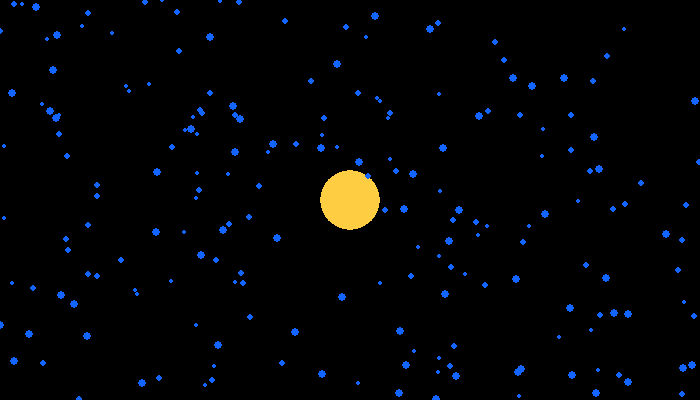

In [13]:
G = 10


class Planet(BaseAgent):
    
    def __init__(self,x,y,mass,radius,mobile = True,*args,**kwargs):
        
        self.mass = mass
        self.mobile = mobile
        self._radius = radius
        
        self.r = np.array([x,y],dtype = np.float32)
        self.v = np.array([0,0],dtype = np.float32)
        self.a = np.array([0,0],dtype = np.float32)


        super().__init__(x,y,*args,**kwargs,circle = True,width = radius*2,height = radius*2,collision_method = "circle")
        
    @property
    def blocking(self):
        return False
    
    
    def calculate_acceleration(self):
        
        a = np.array([0,0],dtype = np.float32)
        
        for planet in self.env.objects:
            
            if planet.id != self.id:
            
                r = planet.r - self.r
                a_planet = (G * planet.mass * r) / (np.sum(r**2)**(3./2))
                a += a_planet
            
        return a

    
    
    def step_euler(self,dt):
        
#         if self.mass < 500:
#             print(self.a[0],self.v[0],self.r[0])
# #         print("sun" if self.mass > 20 else "earth"," ->", self.a,self.v,self.r)
        
        self.r += self.v * dt # Forward euler pass
        self.a = self.calculate_acceleration()
        self.v += self.a * dt  # Backward euler pass (acceleration is updated)
    
    
    def step(self):
        
        if self.mobile:

            self.step_euler(1)
            x = int(self.r[0])
            y = int(self.r[1])
            self.move_at(x,y)
            
    def when_blocked(self,collisions):
        if self.mobile:
            self.kill()
            self.env.finish_episode()
        
    
sun = Planet(350,200,mass = 100,radius = 30,color = (255,205,66),mobile = False)
spawner = lambda x,y: Planet(x,y,mass = np.random.randint(10,30),radius = np.random.randint(2,5),color = (20,100,255))

class Space(SpatialEnvironment):
    
    def compute_reward(self):
        return 1
    
    
    def post_step(self):
        pass
    
    def is_out(self):
        for obj in self.objects:
            x,y = obj.x,obj.y
            if x < 0 or y < 0 or x > self.width or y > self.height:
                self.finish_episode()


env = Space(width = 700,height = 400,objects = [sun],toroidal = False)
env.spawn(spawner,200,allow_overlap = True)

for item in env.objects:
    item.v += np.random.randn(2) / 5
    
env.render()
env.get_img()

In [14]:
sim = Simulation(env,fps = 50)
reward = sim.run_episode(n_steps = 100,replay = True,fps_replay = 25,render = True,save = True)

[INFO] Saving video at ./captures/Simulation_1595325308.mp4



interactive(children=(Play(value=0, description='Press play', interval=40), Output()), _dom_classes=('widget-i…

IntSlider(value=0)

# Agregat

In [ ]:
G = 10


class Planet(BaseAgent):
    
    def __init__(self,x,y,mass,radius,mobile = True,*args,**kwargs):
        
        self.mass = mass
        self.mobile = mobile
        self._radius = radius
        
        self.r = np.array([x,y],dtype = np.float32)
        self.v = np.array([0,0],dtype = np.float32)
        self.a = np.array([0,0],dtype = np.float32)


        super().__init__(x,y,*args,**kwargs,circle = True,width = radius*2,height = radius*2,collision_method = "circle")
        
    @property
    def blocking(self):
        return False
    
    
    def calculate_acceleration(self):
        
        a = np.array([0,0],dtype = np.float32)
        
        for planet in self.env.objects:
            
            if planet.id != self.id:
            
                r = planet.r - self.r
                a_planet = (G * planet.mass * r) / (np.sum(r**2)**(3./2))
                a += a_planet
            
        return a

    
    
    def step_euler(self,dt):
        
#         if self.mass < 500:
#             print(self.a[0],self.v[0],self.r[0])
# #         print("sun" if self.mass > 20 else "earth"," ->", self.a,self.v,self.r)
        
        self.r += self.v * dt # Forward euler pass
        self.a = self.calculate_acceleration()
        self.v += self.a * dt  # Backward euler pass (acceleration is updated)
    
    
    def step(self):
        
        if self.mobile:

            self.step_euler(1)
            x = int(self.r[0])
            y = int(self.r[1])
            self.move_at(x,y)
            
    def when_blocked(self,collisions):
        if self.mobile:
            self.kill()
            self.env.finish_episode()
        
    
sun = Planet(350,200,mass = 100,radius = 30,color = (255,205,66),mobile = False)
spawner = lambda x,y: Planet(x,y,mass = np.random.randint(10,30),radius = np.random.randint(2,5),color = (20,100,255))

class Space(SpatialEnvironment):
    
    def compute_reward(self):
        return 1
    
    
    def post_step(self):
        pass
    
    def is_out(self):
        for obj in self.objects:
            x,y = obj.x,obj.y
            if x < 0 or y < 0 or x > self.width or y > self.height:
                self.finish_episode()


env = Space(width = 700,height = 400,objects = [sun],toroidal = False)
env.spawn(spawner,200,allow_overlap = True)

for item in env.objects:
    item.v += np.random.randn(2) / 5
    
env.render()
env.get_img()